In [9]:
import matplotlib.pyplot as plt
%load_ext autoreload
#!pip install -r requirements.txt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]


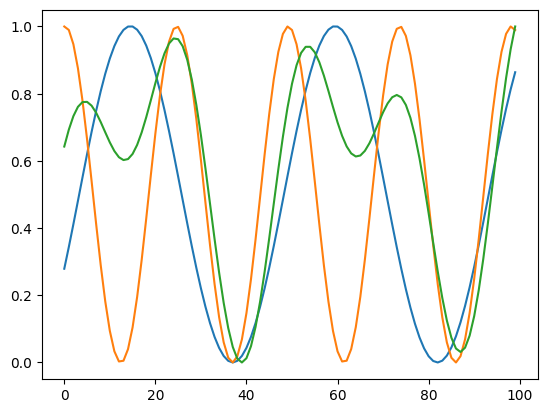

In [4]:
import torch
%load_ext autoreload
import neptune.new as neptune
from trainers import timegan_generate_data, rtsgan_generator, rgan_generate_data
from utils import *
import random

# Makes sure the same testset is generated every time
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
alpha = 0.7
noise = 0
testset = DatasetSinus(num=1000, seq_len=100, alpha=alpha, noise=noise)
plt.plot(testset[:][0][2]);

In [47]:
%autoreload
# Models
#from architectures.timegan_cnn_DG import *
#from architectures.timegan_cnn_D import *
#from architectures.timegan_cnn_G import *
#from architectures.timegan_cnn_DGER import *
#from architectures.timegan import *
#from architectures.RGAN import *
from architectures.RTSGAN import *

print(f"Loading architecture: {ID}")

Loading architecture: RTSGAN


In [48]:
#run_id = "TIMEGAN-218" # RTSGAN-66
#run_id = "RTSGAN-127"
#run_id = "TIMEGAN-185" # er RGAN
run_id = "RTSGAN-128"

project_name = "timeGAN" if "TIME" in run_id else "RTSGAN"
run = neptune.init_run(
                with_id=run_id, # "TIMEGAN-84"
                project="kohmann/" + project_name,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
                   )
params = run["parameters"].fetch()
#imgs = run["generated_image"].download()
params["device"] = "cpu"
params["testset_size"] = len(testset)
#params["model_name"] = "model_checkpoint.pt"

if "TimeGAN" in ID:
    model = TimeGAN(params)
elif ID == "RGAN":
    model = RGAN(params)
elif ID == "RTSGAN":
    model = RTSGAN(params)
else:
    raise ValueError
model = restore_weights(model, run)


https://app.neptune.ai/kohmann/RTSGAN/e/RTSGAN-128
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/RTSGAN/e/RTSGAN-128


In [49]:
model

RTSGAN(
  (encoder): Encoder(
    (emb_rnn): GRU(3, 40, num_layers=2, batch_first=True)
    (fc1): Linear(in_features=120, out_features=40, bias=True)
    (activation): LeakyReLU(negative_slope=0.2)
    (fc2): Linear(in_features=80, out_features=80, bias=True)
  )
  (decoder): Decoder(
    (emb_rnn): GRU(40, 40, num_layers=2, batch_first=True)
    (fc1): Linear(in_features=40, out_features=3, bias=True)
    (sigmoid): Sigmoid()
  )
  (generator): Generator(
    (block_0): Sequential(
      (0): Linear(in_features=120, out_features=120, bias=True)
      (1): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (block_1): Sequential(
      (0): Linear(in_features=120, out_features=120, bias=True)
      (1): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (block_2): Sequential(
      (0): Linear(in_features=120, out_features=120, bias=True)
      (1): LayerNorm((120,), eps=1e-05, e

In [50]:
%autoreload
np.random.seed(42)
if "TimeGAN" in ID:
    fake_data = timegan_generate_data(model, torch.tensor(testset.T), params["max_seq_len"], params["Z_dim"])
elif ID == "RGAN":
    fake_data = rgan_generate_data(model, torch.tensor(testset.T), params["max_seq_len"], params["Z_dim"])
elif ID == "RTSGAN":
    fake_data = rtsgan_generator(model, params, eval=True)
else:
    raise ValueError


Generating Data...Done


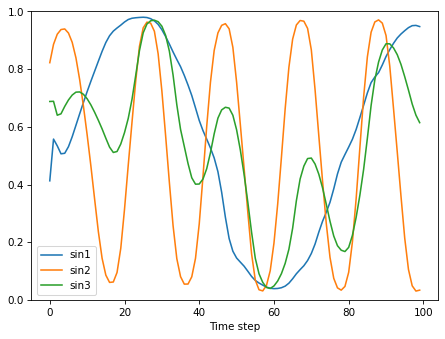

In [55]:
fig, ax = plt.subplots(figsize=(7,5), dpi=75)
plt.plot(fake_data[3], label=["sin1", "sin2", "sin3"]);
plt.xlabel("Time step")
plt.ylim(0, 1)
plt.legend()
plot_name = ID + "-" + run_id.split("-")[-1]
#plt.savefig("results_plots/" + plot_name +".png")

#### Evaluation methods

https://app.neptune.ai/kohmann/Evaluation/e/EV-46
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]
MSE Error: 0.00604


/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Epoch: 299, Train loss: 0.0000, Val loss: 0.0000: 100%|██████████| 300/300 [05:48<00:00,  1.16s/it]

Average Validation MSE: 0.00002437, Average Test MSE: 0.00062891 
Shutting down background jobs, please wait a moment...


Done!
Waiting for the remaining 26 operations to synchronize with Neptune. Do not kill this process.
All 26 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/Evaluation/e/EV-46


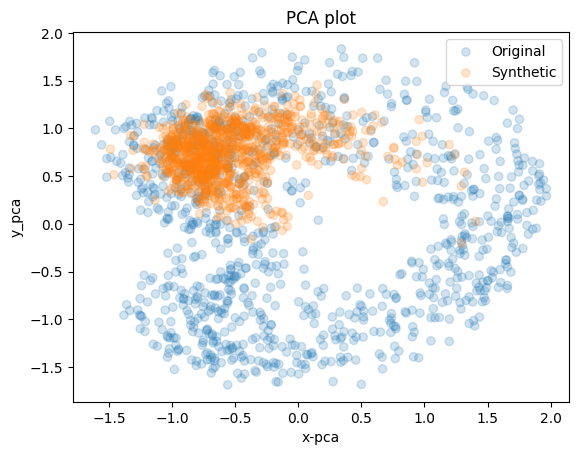

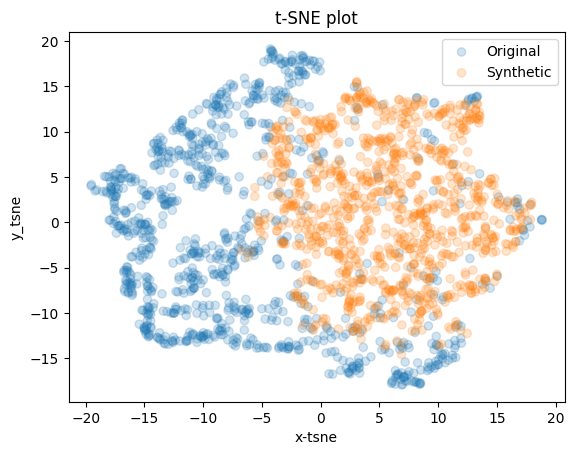

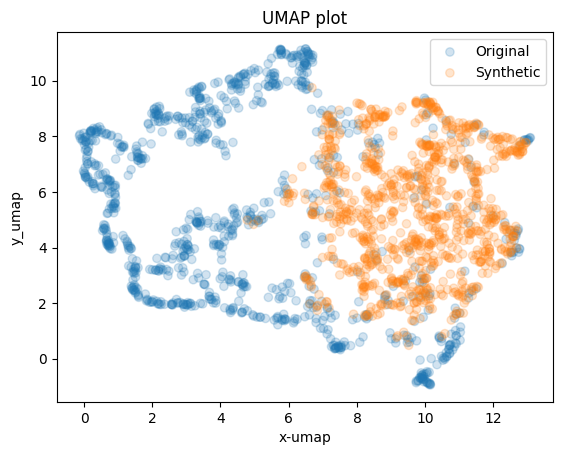

In [52]:
run = neptune.init_run(
    project="kohmann/Evaluation",
    name=ID,
    description="",
    #source_files=["architectures/RTSGAN.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)
run["model_id"] = ID + "-" + run_id.split('-')[-1]

from metrics import compare_sin3_generation, sw_approx, prediction_score # sinkhorn_distance, MMD,
np.random.seed(41)
testset2 = DatasetSinus(num=params["testset_size"], seq_len=100, alpha=alpha, noise=noise)
mse_error = compare_sin3_generation(fake_data, alpha, noise)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data)
y = testset[:][0]
y_2 = testset2[:][0]

y = y.reshape(params["testset_size"] * 100,-1)
y_2 = y_2.reshape(params["testset_size"] * 100,-1)
x = x.reshape(params["testset_size"] * 100,-1)
sw_baseline = sw_approx(y,y_2)
sw = sw_approx(y,x)

run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/sin3_generation_MSE_loss"] = mse_error

run["numeric_results/SW"] = sw.item()
run["numeric_results/SW_baseline"] = sw_baseline.item()

r = np.array([data[0].numpy() for data in testset])

run["PCA"].upload(visualization(r, fake_data, 'pca'))
run["tSNE"].upload(visualization(r, fake_data, 'tsne'))
run["UMAP"].upload(visualization(r, fake_data, 'umap'))

div = int(len(fake_data)*0.8)
val_loss, test_loss = prediction_score(fake_data[:div], fake_data[div:], testset[:][0], device="cpu", epochs=300, neptune_logger=run)
run["numeric_results/Predtion_score_mean_val"] = np.mean(val_loss).item()
run["numeric_results/Predtion_score_std_val"] = np.std(val_loss).item()

run["numeric_results/Predtion_score_mean_test"] = np.mean(test_loss).item()
run["numeric_results/Predtion_score_std_test"] = np.std(test_loss).item()
run.stop()

https://app.neptune.ai/kohmann/Evaluation/e/EV-34
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]


/notebooks/master-GAN/TimeGAN/metrics.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  sins3_fake = torch.tensor(sins3_fake)


MSE Error: 0.00822


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Epoch: 299, Train loss: 0.0003, Val loss: 0.0003: 100%|██████████| 300/300 [01:23<00:00,  3.58it/s]

Average Validation MSE: 0.00031194, Average Test MSE: 0.00025032 
Shutting down background jobs, please wait a moment...


Done!
Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
All 14 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/Evaluation/e/EV-34


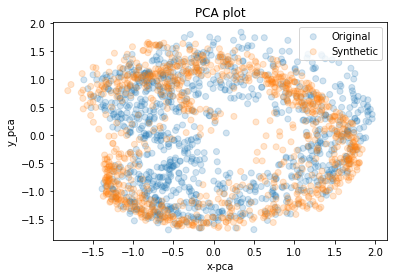

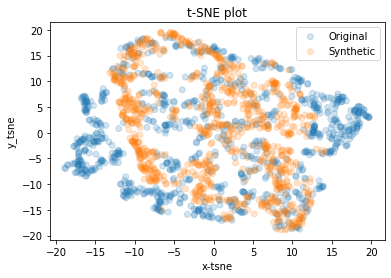

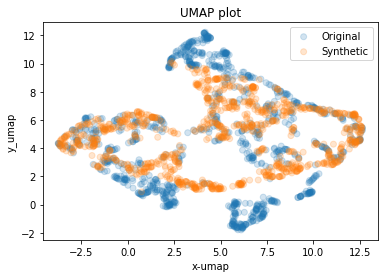

In [ ]:
import glob
from PIL import Image

def create_gif(fp_in="neptune/generated_image/*.png", fp_out="neptune/mnist_generation.gif"):
    imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    # extract first image from iterator
    imgs[0].save(fp=fp_out, append_images=imgs,
                 save_all=True, duration=500, loop=0)
    
create_gif()

In [33]:
import numpy as np
def create_sin3(sin1, sin2, alpha, noise):
    seq_len = len(sin1)
    importance = np.array([alpha ** i for i in range(seq_len)])

    if alpha < 1:
        sin3 = []
        for i in range(1, seq_len + 1):
            sin3.append(((importance[:i][::-1] * sin1[:i] + importance[:i][::-1] * sin2[:i]) / 2).sum())
        sin3 = np.array(sin3)
    else:
        sin3 = (sin1 + sin2) / 2

    return sin3

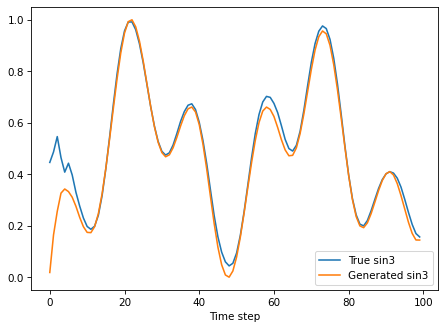

In [48]:
fig, ax = plt.subplots(figsize=(7,5), dpi=75)
sins1_fake = fake_data[:, :, 0]
sins2_fake = fake_data[:, :, 1]
sins3_real = fake_data[:, :, 2]

sins3_fake = []
for sin1, sin2 in zip(sins1_fake, sins2_fake):
    sins3_fake.append(create_sin3(sin1, sin2, alpha, noise))
sins3_fake = torch.tensor(sins3_fake)
sin3_fake_norm = minmaxscaler().fit_transform(sins3_fake)
mse_error = ((sin3_fake_norm - sins3_real)**2 )
plt.plot(sins3_real[3], label="True sin3")
plt.plot(sin3_fake_norm[3], label="Generated sin3")
plt.xlabel("Time step")

plt.legend()

#plt.savefig("results_plots/" + "TimeGAN_sin3_trueVSgen" +".png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


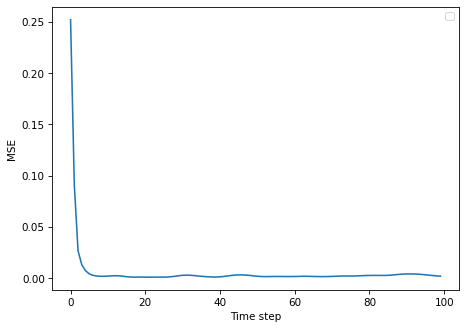

In [35]:
fig, ax = plt.subplots(figsize=(7,5), dpi=75)
#plt.plot(fake_data[2], label=["sin1", "sin2", "sin3"]);
plt.plot(mse_error.mean(axis=0))
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.legend()
plot_name = ID + "-" + run_id.split("-")[-1]
#plt.savefig("results_plots/" + plot_name +".png")



In [80]:
testdata = testset[:][0].to("cuda")

In [62]:
# RTSGAN
model.to("cuda")
X_h = model.encoder(testdata)
X_hat = model.decoder(X_h)

In [83]:
# TimeGAN
testdata = testset[:][0].to("cuda")
model.to("cuda")
T = testset[:][1]#.to("cuda")
X_h = model.embedder(testdata, T)
X_hat = model.recovery(X_h, T)

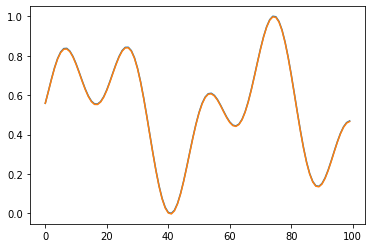

In [104]:
n = 113
plt.plot(testdata[n].detach().cpu()[:, 2], label="True");
plt.plot(X_hat[n].detach().cpu()[:, 2], label="Reconstructed");

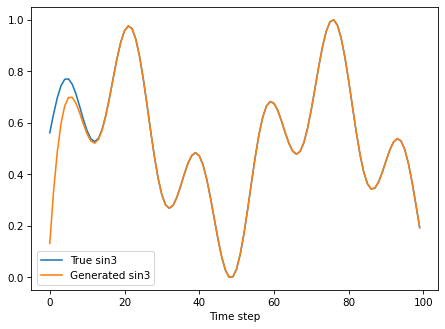

In [112]:
fig, ax = plt.subplots(figsize=(7,5), dpi=75)
sins1_fake = X_hat[:, :, 0].detach().cpu().numpy()
sins2_fake = X_hat[:, :, 1].detach().cpu().numpy()
sins3_real = testdata[:, :, 2].detach().cpu().numpy()

sins3_fake = []
for sin1, sin2 in zip(sins1_fake, sins2_fake):
    sins3_fake.append(create_sin3(sin1, sin2, alpha, noise))
sins3_fake = torch.tensor(sins3_fake)
sin3_fake_norm = minmaxscaler().fit_transform(sins3_fake)
mse_error = ((sin3_fake_norm - sins3_real)**2 )

plt.plot(sins3_real[0], label="True sin3")
plt.plot(sin3_fake_norm[0], label="Generated sin3")
plt.xlabel("Time step")

plt.legend()

#plt.savefig("results_plots/" + "TimeGAN_sin3_trueVSgen" +".png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


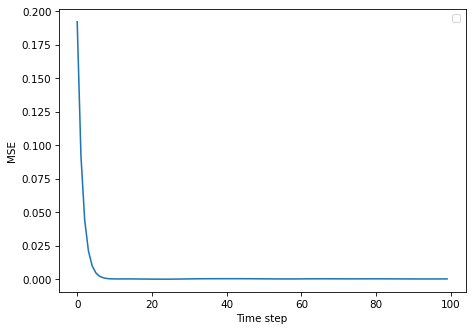

In [86]:
fig, ax = plt.subplots(figsize=(7,5), dpi=75)
#plt.plot(fake_data[2], label=["sin1", "sin2", "sin3"]);
plt.plot(mse_error.mean(axis=0))
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.legend()
plot_name = ID + "-" + run_id.split("-")[-1]
#plt.savefig("results_plots/" + plot_name +".png")



In [87]:
mse_error.mean()

tensor(0.0039, dtype=torch.float64)

In [ ]:
if s1_freq is None:
    s1_freq = [1, 3]
    #s1_freq = [0.05, 0.15]
if s2_freq is None:
    s2_freq = [4, 6]
    #s2_freq = [0.3, 0.4]
if s1_phase is None:
    s1_phase = [-np.pi/2, 0]
    #s1_phase = [-np.pi / 2, 0]
if s2_phase is None:
    s2_phase = [0, np.pi/2]
    #s2_phase = [0, np.pi / 2]

In [ ]:

testset = DatasetSinus(num=4, seq_len=100, alpha=alpha, noise=noise, s1_freq=[1,2], s2_freq=[4, 4])
fig, ax = plt.subplots(figsize=(7,5), dpi=75)
plt.plot(testset[0][0]);

In [ ]:
fig, ax = plt.subplots(figsize=(7,5), dpi=75)